# Notebook for RDE activity analysis

See analysis_RDE.py for more information about the functions.

### 1. Initialization.

In [1]:
%load_ext autoreload
from analysis_RDE import *
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox
import os
import pandas as pd
from numpy import savetxt

root = tk.Tk()
root.withdraw()
root.lift()
root.attributes("-topmost", True)

''

### 1.1 Introducting experimental parameters.

In [2]:
reference = 0               # V
A_geo = 0.196               # cm2
loading = 0.02              # mg/cm2
ir_comp = 26                # ohm
charge_ecsa = 0.000210      #C/cm2
Pt_mass = loading * A_geo   #mg
scan_rate = 0.05            #V/s for CO stripping

index = 10                  # number of lines of info to be removed

### 2. Choose which file(s) to analyze.

#### 2A. Analysis of one file: Open the file with the interesting voltage and current data.

In [3]:
%autoreload
nbr_files = 1
file = filedialog.askopenfilename(title="Choose the file to be analyzed.")
V, I = get_voltage_current(file, index)
print(file)

L:/P15 SEM/Linnéa/2024_02_07/Activity/ML00_M028_Cyc0001.txt


#### 2B. Analysis of several files: Open the files with the interestig voltage and current data.

In [38]:
%autoreload
nbr_files = 2 #not important, just not 1
files = filedialog.askopenfilenames(title="Choose the files to be analyzed.")
print(files)
data_matrix = []

for file in files: 
    V_i, I_i = get_voltage_current(file, index)
    data_matrix.append(V_i)
    data_matrix.append(I_i)

data_matrix = np.transpose(data_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_02_07/Activity/ML00_M016_Cyc0015.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Activity/ML00_M017_Cyc0003.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Activity/ML00_M018_Cyc0003.txt', 'L:/P15 SEM/Linnéa/2024_02_07/Activity/ML00_M019_Cyc0003.txt')


##### 2B.1 Optional: Rearrange the data so it's stored with the lowest rotation rate first.

In [39]:
V_400 = data_matrix[:,6]
I_400 = data_matrix[:,7]
data_matrix = np.insert(data_matrix, 0, V_400, axis=1)
data_matrix = np.insert(data_matrix, 1, I_400, axis=1)
data_matrix = np.delete(data_matrix, 8, axis=1)
data_matrix = np.delete(data_matrix, 8, axis=1)

### 3. Introduce background: choose the corresponding file(s).

In [12]:
%autoreload
if nbr_files == 1:
    background_file = filedialog.askopenfilename(title="Choose the background file.")
    print(background_file)
    background_V, background_I = get_background(background_file, index)
else:
    background_files = filedialog.askopenfilenames(title="Choose the background files.")
    print(background_files)
    background_matrix = []
    for i, background_file in enumerate(background_files): 
        V_i, I_i = get_background(background_file, index)
        background_matrix.append(V_i)
        background_matrix.append(I_i)

    background_matrix = np.transpose(background_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_02_07/Activity/ML00_M004_Cyc0003.txt',)


### 4. Corrections.
The following corrections can be made:
* Adjusting voltage to RHE potential.
* Background adjustment of current.
* iR-drop correction (usually done directly by Labview).

In [29]:
%autoreload
if nbr_files == 1:
    background_V_RHE = copy.deepcopy(background_V)
    background_I_RHE = copy.deepcopy(background_I)
    V_RHE = copy.deepcopy(V)
    I_corrected = copy.deepcopy(I)

    V_RHE = RHE_correction(V_RHE, reference)
    I_corrected = background_correction_current(I_corrected, background_I_RHE)   
else:
    background_RHE = copy.deepcopy(background_matrix)
    background_RHE = RHE_correction_background(background_RHE, reference)
    data_RHE = copy.deepcopy(data_matrix)
    corrected_data_RHE = copy.deepcopy(data_matrix)
    
    for i in range(len(data_matrix[0])):
        if i % 2 == 0:      #voltage are stored in even indexed columns
            data_RHE[:,i] = RHE_correction(data_RHE[:,i], reference)
            corrected_data_RHE[:,i] = RHE_correction(corrected_data_RHE[:,i], reference)
        else:               #current
            corrected_data_RHE[:,i] = background_correction_current(corrected_data_RHE[:,i], background_RHE[:,1])
            #last index need to be changed to i if you have one background file for each data file

### 5. Normalizing to geometric surface area and mass.

In [15]:
%autoreload
if nbr_files == 1:
    mass_I = copy.deepcopy(I_corrected)
    surface_I = copy.deepcopy(I_corrected)

    mass_I, surface_I = normalizing(mass_I, loading, A_geo)
else:
    mass_matrix = copy.deepcopy(corrected_data_RHE)
    surface_matrix = copy.deepcopy(corrected_data_RHE) 

    for i in range(1, len(data_matrix[0]), 2):  #only looping the current columns
        mass_matrix[:,i], surface_matrix[:,i] = normalizing(mass_matrix[:,i], loading, A_geo)

### 6. Plotting

#### 6A. Plotting one file.

Text(0.5, 1.0, 'CO stripping & background CV')

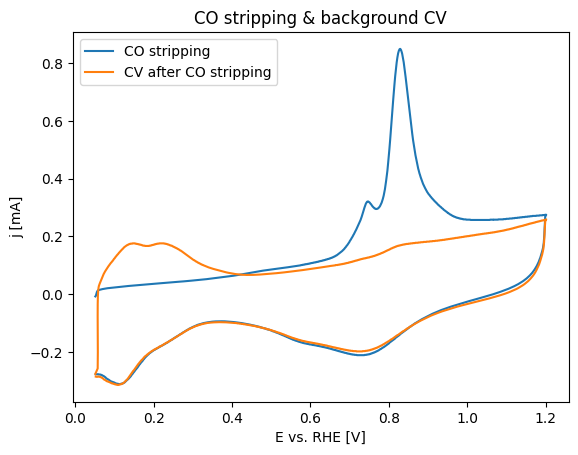

In [10]:
plt.plot(V, [1000*i for i in I], label='CO stripping')
plt.plot(background_V, [1000*i for i in background_I], label='CV after CO stripping')
plt.xlabel('E vs. RHE [V]')
plt.ylabel('j [mA]')
plt.legend()
plt.title('CO stripping & background CV')

#### 6B: Plotting several files.

Text(0.5, 1.0, 'Surface normalization')

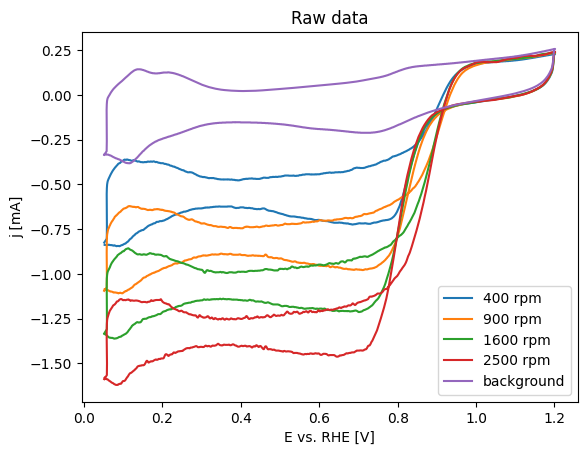

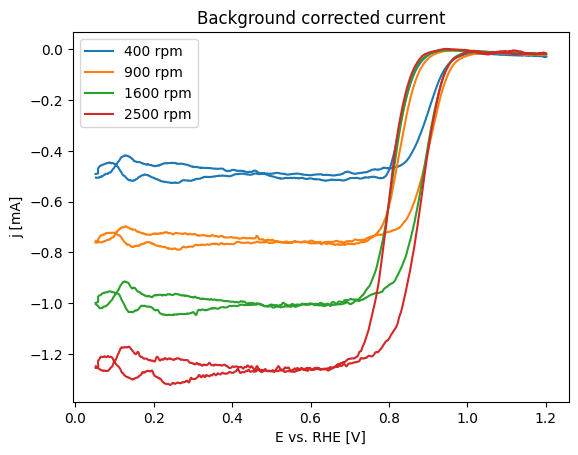

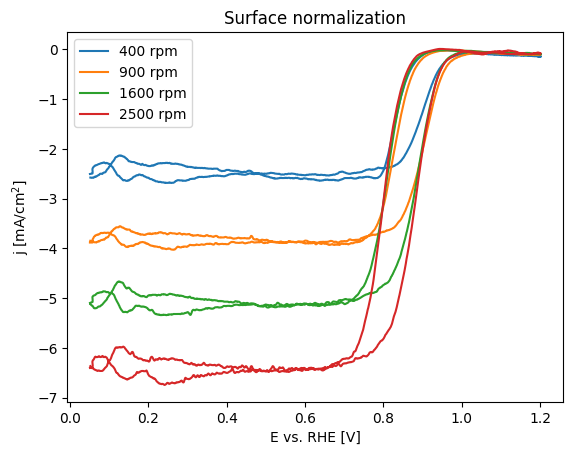

In [42]:
legend = ["400 rpm", "900 rpm", "1600 rpm", "2500 rpm", "background"]

fig1, ax1 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax1.plot(data_matrix[:,i], [1000*e for e in data_matrix[:,i+1]])
ax1.plot(background_RHE[:,0], [1000*e for e in background_RHE[:,1]])
ax1.legend(legend, loc='lower right')  
ax1.set_xlabel('E vs. RHE [V]')
ax1.set_ylabel('j [mA]')
ax1.set_title('Raw data')

fig2, ax2 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax2.plot(corrected_data_RHE[:,i],[1000*e for e in corrected_data_RHE[:,i+1]])
ax2.legend(legend)
ax2.set_xlabel('E vs. RHE [V]')
ax2.set_ylabel('j [mA]')
ax2.set_title('Background corrected current')

fig3, ax3 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax3.plot(surface_matrix[:,i],surface_matrix[:,i+1])
ax3.legend(legend)
ax3.set_xlabel('E vs. RHE [V]')
ax3.set_ylabel('j [mA/cm$^2$]')
ax3.set_title('Surface normalization')

### 7. Analysis.

##### 7.1 ECSA & Specific activity.
Look at the CO stripping file.

ECSA: 5.1549832857142865 cm2
Specific ECSA: 131.5046756559767 m2/g(Pt)


Text(0.5, 1.0, 'CO stripping minus background')

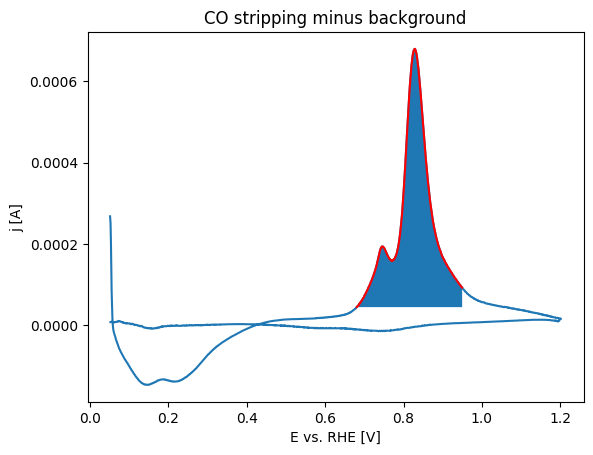

In [43]:
# Choose x-region to look at the ECSA (HUPD, CO stripping peak)
lower_limit = 0.68
upper_limit = 0.95

voltage = copy.deepcopy(V_RHE)
current = copy.deepcopy(I_corrected)

# Finding the closest data point to the given values
integration_start = next(x for x in voltage if x >= lower_limit)
integration_end = next(x for x in voltage if x >= upper_limit)
integration_interval = slice(voltage.index(integration_start), voltage.index(integration_end))
height = current[voltage.index(integration_start)]   #baseline - current value at integration start

#Integrating
charge = np.trapz(current[integration_interval], voltage[integration_interval]) - height * (upper_limit - lower_limit)
charge = charge / scan_rate           # V*A/(V/s)=A*s=C
ECSA = np.abs(charge / charge_ecsa)   # C/(C/cm2)=cm2
specific_ECSA = ECSA / Pt_mass * 0.1  #converison to m2/g(Pt)
print('ECSA:', ECSA, 'cm2'
      '\nSpecific ECSA:', specific_ECSA, 'm2/g(Pt)')

plt.plot(voltage, current)
plt.plot(voltage[integration_interval], current[integration_interval], 'red')
plt.fill_between(voltage[integration_interval], current[integration_interval], height)
plt.xlabel('E vs. RHE [V]')
plt.ylabel('j [A]')
plt.title('CO stripping minus background')

$SA = \frac{\frac{I*I_d}{I_d-I}}{ECSA} = \frac{I_k}{ECSA}$

In [44]:
diffusion_voltage = 0.40
kinetic_voltage = 0.90

# Extracting I and I_d (in A)
V09_index = []
I_measured = []        
I_d = []
for i in range(len(corrected_data_RHE[0])):
    if i % 2 == 0:
        V_list = list(corrected_data_RHE[:,i])
        V09_elm = next(x for x in V_list if x >= kinetic_voltage)
        V09_index = V_list.index(V09_elm)
        V04_elm = next(x for x in V_list if x >= diffusion_voltage)
        V04_index = V_list.index(V04_elm)
    else:
        I_list = list(corrected_data_RHE[:,i])
        I_measured.append(I_list[V09_index])
        I_d.append(I_list[V04_index])

I_k = []
for i in range(len(I_measured)):
    elm = I_measured[i]*I_d[i]/(I_d[i]-I_measured[i])
    I_k.append(np.abs(elm))

SA = [i*1000 for i in I_k]/ECSA
print('Specific activity at 0.9 V [mA/cm2]:'
      '\n400 rpm\t\t', SA[0], '\n900 rpm\t\t', SA[1], '\n1600 rpm\t', SA[2], '\n2500 rpm\t', SA[3],)

Specific activity at 0.9 V [mA/cm2]:
400 rpm		 0.09235603165588478 
900 rpm		 0.16119134325597717 
1600 rpm	 0.11566613384722212 
2500 rpm	 0.11144350515480139


##### 7.2 Koutecký-Levich analysis

KL equation: $\frac{1}{i} = \frac{1}{i_k} + \frac{1}{i_m}$

$i$: measured current  
$i_k$: kinetic current, electron transfer limitations   
$i_m$: mass transfer limited current

$\frac{1}{i} = \frac{1}{nFC_Rk_f} + \frac{1}{0.62nFAC_RD^{2/3}\nu^{-1/6}} \cdot \frac{1}{\omega^{1/2}}$

Diffusion region: y= -13.237 * x + 0.04
Kinetic region: y= -17.12 * x +  -1.256

R-value diffusion model:  0.999319979049247 
R-value kinetic model:  0.8008217407886193


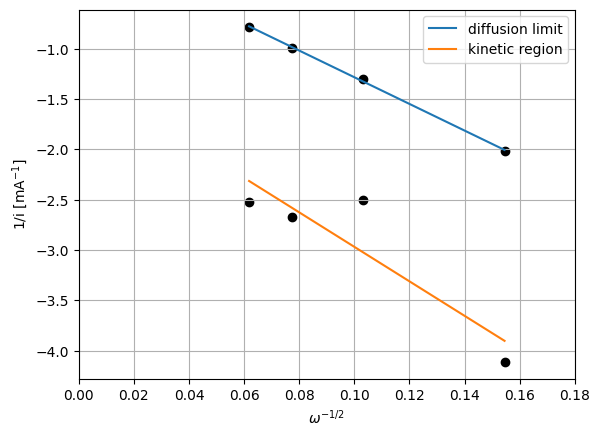

In [36]:
F = 96485
C = 1.2*pow(10,-6)
D23 = 7.12*pow(10,-4)
nu = 2.15443469

f = [400, 900, 1600, 2500]   #rpm
w = [2*np.pi*i/60 for i in f]   #to rad/s

diffusion_voltage = 0.40
kinetic_voltage = 0.90

diffusion_points = []
kinetic_points = []
for i in range(0,len(corrected_data_RHE[0]),2):  
    V_list = list(corrected_data_RHE[:,i])
    elm_i_diffusion = next(x for x in V_list if x >= diffusion_voltage)
    point_i_diffusion = corrected_data_RHE[V_list.index(elm_i_diffusion)][i+1]
    diffusion_points.append(point_i_diffusion)

    elm_i_kinetic = next(x for x in V_list if x >= kinetic_voltage)
    point_i_kinetic = corrected_data_RHE[V_list.index(elm_i_kinetic)][i+1]
    kinetic_points.append(point_i_kinetic)

x = [1/np.sqrt(i) for i in w]
y_diffusion = [1/(1000*i) for i in diffusion_points]
y_kinetic = [1/(1000*i) for i in kinetic_points]

# Linear regression
model1 = np.polyfit(x,y_diffusion,1)
print("Diffusion region: y=",round(model1[0],3),"* x +", round(model1[1],3))
predict1 = np.poly1d(model1)

model2 = np.polyfit(x,y_kinetic,1)
print("Kinetic region: y=",round(model2[0],3),"* x + ", round(model2[1],3))
predict2 = np.poly1d(model2)

#Model accuracy
from sklearn.metrics import r2_score
R2_diffusion = r2_score(y_diffusion, predict1(x))
R2_kinetic = r2_score(y_kinetic, predict2(x))
print('\nR-value diffusion model: ',R2_diffusion,'\nR-value kinetic model: ',R2_kinetic)

#Plotting
x_lin_reg = np.linspace(np.min(x), np.max(x))
plt.scatter(x, y_diffusion, c="black")
y_reg_diffusion = predict1(x_lin_reg)
plt.plot(x_lin_reg, y_reg_diffusion, label = "diffusion limit")

plt.scatter(x, y_kinetic, c="black")
y_reg_kinetic = predict2(x_lin_reg)
plt.plot(x_lin_reg, y_reg_kinetic, label = "kinetic region")

plt.xlabel("$\\omega^{-1/2}$")
plt.ylabel("1/i [mA$^{-1}$]")
plt.xlim([0, 0.18])   #this might need to be adjusted
plt.grid()
plt.legend()